In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2024-06-18 15:41:12.746731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 15:41:12.746857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 15:41:12.879506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define paths to your datasets
train_dir = '/kaggle/input/dataff/dataF/train'
test_dir = '/kaggle/input/dataff/dataF/test'

# Parameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 30

In [3]:
# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split to 20%
)

# Rescaling for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating the training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Creating the validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Use same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Creating the test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7116 images belonging to 3 classes.
Found 1778 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [4]:
# Get class labels
class_labels = train_generator.classes

# Encode the class labels as integers
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(class_labels)
print("Encoded labels:", integer_encoded_labels)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(integer_encoded_labels),
    y=integer_encoded_labels
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights)

Encoded labels: [0 0 0 ... 2 2 2]
Class weights: {0: 0.6753986332574032, 1: 3.2944444444444443, 2: 0.8224687933425797}


In [5]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and summarize the CNN model
input_shape = (img_height, img_width, 3)
cnn_model = create_cnn_model(input_shape)
cnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_checkpoint = ModelCheckpoint('best_cnn_model.keras', save_best_only=True)

# Train the CNN model
history_cnn = cnn_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, cnn_checkpoint]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/223 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.2109 - loss: 2.5856 

I0000 00:00:1718725313.568170      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718725313.587392      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


169/223 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.4465 - loss: 1.2242

W0000 00:00:1718725411.153085      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.4642 - loss: 1.1531

W0000 00:00:1718725440.060861      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718725472.504373      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


223/223 ━━━━━━━━━━━━━━━━━━━━ 177s 726ms/step - accuracy: 0.4645 - loss: 1.1520 - val_accuracy: 0.6805 - val_loss: 0.6806
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 115s 501ms/step - accuracy: 0.6108 - loss: 0.7569 - val_accuracy: 0.7593 - val_loss: 0.5590
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 139s 489ms/step - accuracy: 0.7085 - loss: 0.6177 - val_accuracy: 0.7441 - val_loss: 0.6133
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 114s 501ms/step - accuracy: 0.7504 - loss: 0.5298 - val_accuracy: 0.7992 - val_loss: 0.4997
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 489ms/step - accuracy: 0.7921 - loss: 0.4757 - val_accuracy: 0.7818 - val_loss: 0.5620
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 115s 503ms/step - accuracy: 0.7862 - loss: 0.4866 - val_accuracy: 0.8076 - val_loss: 0.4809
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 491ms/step - accuracy: 0.7985 - loss: 0.4331 - val_accuracy: 0.7688 - val_loss: 0.5496
Epoch 8/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 488ms/step - accuracy: 0.8122 - loss: 0.42

In [6]:
# Save the trained CNN model
cnn_model.save('final_cnn_model.keras')

# Evaluate the CNN model
loss_cnn, accuracy_cnn = cnn_model.evaluate(test_generator)
print(f"Test Accuracy (CNN): {accuracy_cnn*100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - accuracy: 0.6479 - loss: 1.2185
Test Accuracy (CNN): 68.00%


W0000 00:00:1718728133.674595      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [7]:
# Function to create the MobileNetV2 model
def create_mobilenet_model(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze more layers in the base model
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and summarize the MobileNetV2 model
mobilenet_model = create_mobilenet_model((img_height, img_width, 3))
mobilenet_model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
mobilenet_checkpoint = ModelCheckpoint('best_mobilenet_model.keras', save_best_only=True)

# Train the MobileNetV2 model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, mobilenet_checkpoint]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,855,104 (7.08 MB)

 Non-trainable params: 402,880 (1.54 MB)

Epoch 1/30
  2/223 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.2578 - loss: 2.1312   

W0000 00:00:1718728168.507152      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


221/223 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.3486 - loss: 1.8748

W0000 00:00:1718728268.384897      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.3488 - loss: 1.8738

W0000 00:00:1718728273.378079      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718728300.516663      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


223/223 ━━━━━━━━━━━━━━━━━━━━ 165s 597ms/step - accuracy: 0.3493 - loss: 1.8719 - val_accuracy: 0.4966 - val_loss: 1.3185 - learning_rate: 1.0000e-05
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 489ms/step - accuracy: 0.5515 - loss: 1.1702 - val_accuracy: 0.6316 - val_loss: 1.1668 - learning_rate: 1.0000e-05
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 111s 486ms/step - accuracy: 0.6896 - loss: 0.9160 - val_accuracy: 0.6575 - val_loss: 1.1078 - learning_rate: 1.0000e-05
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 113s 494ms/step - accuracy: 0.7747 - loss: 0.7490 - val_accuracy: 0.7171 - val_loss: 0.9853 - learning_rate: 1.0000e-05
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 492ms/step - accuracy: 0.8144 - loss: 0.6419 - val_accuracy: 0.7463 - val_loss: 0.9265 - learning_rate: 1.0000e-05
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 489ms/step - accuracy: 0.8413 - loss: 0.5910 - val_accuracy: 0.7863 - val_loss: 0.8279 - learning_rate: 1.0000e-05
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 113s 494ms/

In [8]:

# Save the trained MobileNetV2 model
mobilenet_model.save('final_mobilenet_model.keras')

# Evaluate the MobileNetV2 model
loss_mobilenet, accuracy_mobilenet = mobilenet_model.evaluate(test_generator)
print(f"Test Accuracy (MobileNetV2): {accuracy_mobilenet*100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - accuracy: 0.9355 - loss: 0.4211
Test Accuracy (MobileNetV2): 93.50%


W0000 00:00:1718730991.067845      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


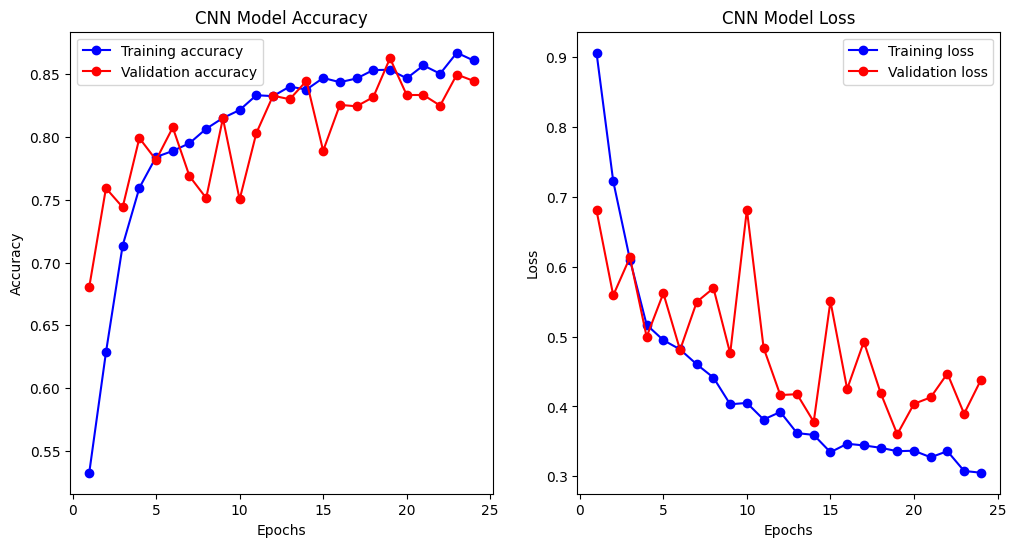

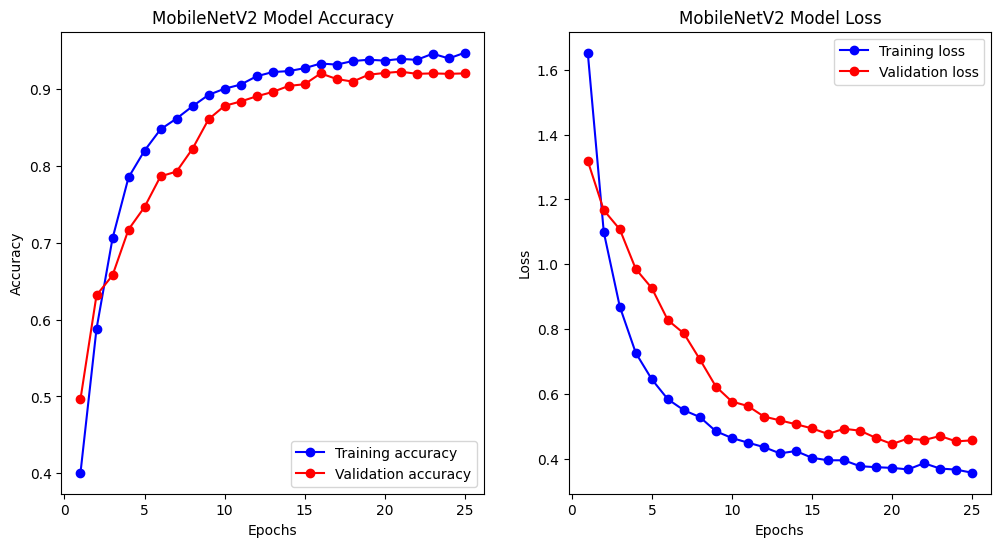

In [9]:
# Plot training history
def plot_training_history(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training history for the CNN model
plot_training_history(history_cnn, title='CNN Model')

# Plot training history for the MobileNetV2 model
plot_training_history(history_mobilenet, title='MobileNetV2 Model')



Predicting for image: /kaggle/input/testing/acc.jpg
CNN Model Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


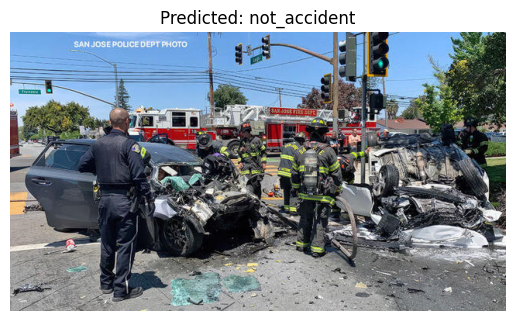

MobileNet Model Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


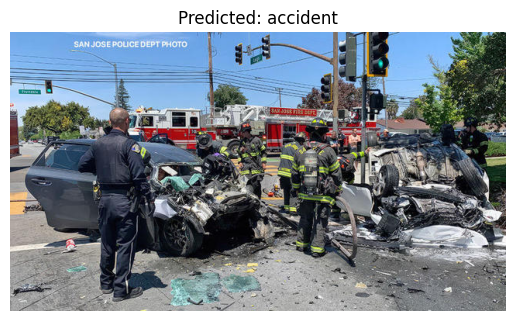

Predicting for image: /kaggle/input/testing/fireAcc.jpg
CNN Model Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


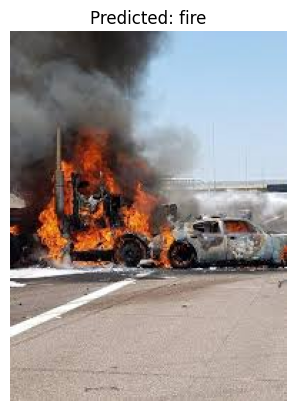

MobileNet Model Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


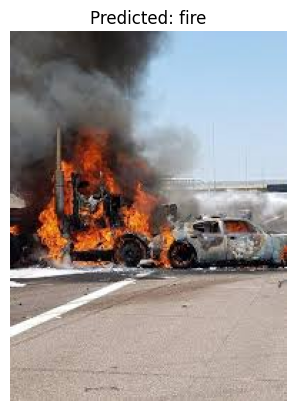

In [10]:
# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

# Function to predict and display the result
def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image
    img = tf.keras.preprocessing.image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Load the class indices from the training generator
class_indices = train_generator.class_indices

# Test with new images
img_paths = [
    '/kaggle/input/testing/acc.jpg',
    '/kaggle/input/testing/fireAcc.jpg'
]

for img_path in img_paths:
    print(f"Predicting for image: {img_path}")
    print("CNN Model Prediction:")
    predict_image_class(cnn_model, img_path, class_indices)
    print("MobileNet Model Prediction:")
    predict_image_class(mobilenet_model, img_path, class_indices)